### Using OpenMP in Cython

https://ipython-books.github.io/57-releasing-the-gil-to-take-advantage-of-multi-core-processors-with-cython-and-openmp/

In [1]:
import Cython
from random import random
import math
import numpy as np
import matplotlib.pyplot as plt

# This is needed to load the Cython magic
%load_ext Cython

## Simple Reduction

In [2]:
%%cython -a

from cython.parallel import prange

def compute_sum_seq(int n):
    cdef int i
    cdef int sum = 0

    for i in range(n):
        sum += i

    return sum

In [3]:
%timeit compute_sum_seq(1_000_000)

74.7 ns ± 3.66 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [6]:
%%cython -a  --compile-args=-fopenmp --compile-args=-02 --compile-args=-march=native --link-args=-fopenmp --force

from cython.parallel import prange

def compute_sum_par(int n):
    cdef int i
    cdef int sum = 0

    for i in prange(n, nogil=True):
        sum += i

    return sum

In [7]:
%timeit compute_sum_par(1_000_000)

168 ns ± 9.94 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


## Julia set

In [8]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0,10000), np.linspace(-2.0, 2.0, 10000))
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0

In [9]:
X.shape

(10000, 10000)

In [11]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
#%%cython  --compile-args=-fopenmp --compile-args=-02 --compile-args=-march=native --link-args=-fopenmp --force

from cython cimport boundscheck, wraparound
from cython.parallel cimport prange

@boundscheck(False)
@wraparound(False)
def julia_set_cython_02(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    ny = X.shape[0]
    nx = X.shape[1]
    for i in range(ny):
        for j in range(nx):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k


In [54]:
%timeit julia_set_cython_01(X, Y, c.real, c.imag, 100, radius2, julia)

3.47 s ± 58.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:

%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

from cython cimport boundscheck, wraparound
from cython.parallel import prange

@boundscheck(False)
@wraparound(False)
def julia_set_cython_02(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    ny = X.shape[0]
    nx = X.shape[1]
    for i in prange(ny, nogil=True, schedule='dynamic'):
        for j in range(nx):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k

In [91]:
%timeit julia_set_cython_02(X, Y, c.real, c.imag, 100, radius2, julia)

3.44 s ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Plotting the result

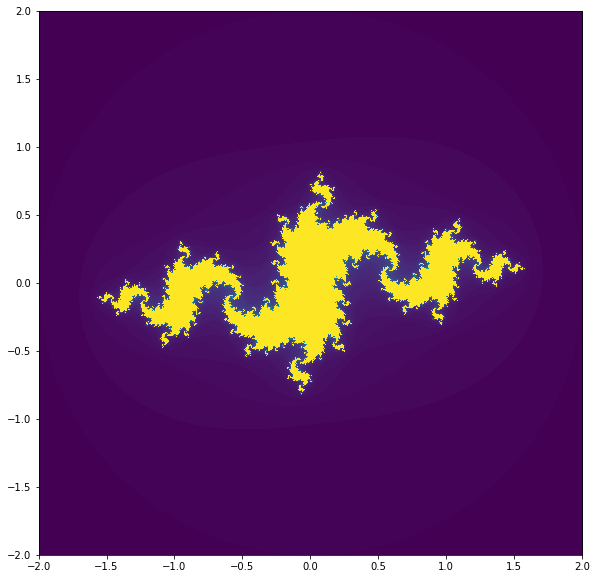

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);